# Lead extraction from L1B thermal MODIS imagery

Routine for extracting sea ice lead coordinates at 5 km geodesic steps from Level1B thermal infrared MODIS imagery.

---
This notebook shows an example routine to extract lead coordinates from a composite image of the Beaufort and Chukchi Seas ice cover on February 20, 2013 from Level1B thermal infrared (band 31) Terra/MODIS imagery files (https://doi.org/10.5067/MODIS/MOD021KM.061, https://doi.org/10.5067/MODIS/MOD03.061). For this example, files were downloaded from the [NASA LAADS DAAC](https://ladsweb.modaps.eosdis.nasa.gov/) and stored locally. All that is needed to run this example routine are the MODIS imagery listed in the `MODIS_file_list.txt` file and the imported packages listed below.

---

There are three main sections of this notebook.

### (1) Plotting imagery around Point Barrow
Open hdf files of L1B thermal infrared MODIS imagery and save to a projected image in grayscale.

### (2) Extracting lead coordinates from projected image
Manually select some lead coordinates and use [sci-kit image active contour model](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.active_contour) to fill in additional coordinates between selected points based on the brightness contrast across leads in thermal images.

### (3) Re-indexing lead coordinates to 5-km geodesic steps
Use [geopy](https://geopy.readthedocs.io/en/stable/) and [metpy](https://unidata.github.io/MetPy/latest/index.html#) to re-index/interpolate lead coordinates to fall along 5-km geodesic steps. 


---
Lines where user input is required will be displayed between double lines as below.

    #======================================
    Folder = '/Users/user/imagery/'
    #======================================
    
 
MODIS files needed for use in this notebook are listed below.

In [1]:
print_string = 'Imagery (MOD021KM) and geolocation (MOD03) files used in this example'
print(f'{print_string}\n{"-"*len(print_string)}')
with open('./example/MODIS_file_list.txt') as f:
    for line in f:
        print(line.strip())

Imagery (MOD021KM) and geolocation (MOD03) files used in this example
---------------------------------------------------------------------
MOD021KM.A2013051.2250.061.2017294211643.hdf
MOD021KM.A2013051.2255.061.2017294211706.hdf
MOD03.A2013051.2250.061.2017294210914.hdf
MOD03.A2013051.2255.061.2017294210634.hdf


# Import packages

In [2]:
# general
import glob
import os
import sys  
import pandas as pd
import numpy as np
from pyhdf.SD import SD, SDC

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors

# geospatial
from geopy.distance import geodesic
import metpy
from metpy import interpolate
from pyproj import CRS
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from shapely import wkt

# temporal
import datetime as dt
from datetime import datetime

# image analysis
from skimage import io
from skimage.filters import gaussian
from skimage.segmentation import active_contour

# import homemade functions from scripts folder 
#********************************************************
sys.path.append('./scripts/')
from LIB_geo_plot_LE import (add_land, add_coast)
from LIB_plot_MODIS_LE import get_MODISdate, load_MODISband, get_MODISgeo, pair_images_meta
from LIB_lead_geom import make_SpacedArray
#********************************************************

# (1) Plotting imagery around Point Barrow 

---
Open hdf files of L1B thermal infrared MODIS imagery and save to a projected image in grayscale. Plot composite image of the Beaufort and Chukchi Seas region from two sets of band 31 MODIS imagery and geolocation files. Save image to **example** folder.

---
### (1A) Import imagery from local directory

In [3]:
# set path for location of level1b imagery and geolocation hdf files
#===================================================================
Folder = '/Users/mackenziejewell/Desktop/imagery/'
#===================================================================

# Load metadata of MODIS files from folder and pair images 
# within 'max_diff_minutes' minutes of one another to plot together as a composite
Image_Meta_paired = pair_images_meta(SingleFolder = Folder, max_diff_minutes=20)

Search in single folder: /Users/mackenziejewell/Desktop/imagery/

Pair 0
------
2013-02-20 22:50:00
2013-02-20 22:55:00



---
### (1B) Specify pair of images to plot

In [4]:
# specify pair of images to plot as list
#=======================================
RunPair = 0
#=======================================

# grab metadata from current_set of paired images
#------------------------------------------------
current_set = Image_Meta_paired[np.where(Image_Meta_paired[:,4]==RunPair)[0]]

# start empty lists to fill with image names, paths, and dates
IMG_file=[]
GEO_file=[]

# add data from all images in current_set to above lists
counter = 0
for image_meta in current_set:
    # grab date and ImageName for saving from first file in current_set
    if counter == 0:
        ImageDate = image_meta[0]
        ImageName = image_meta[2][0:22]
    IMG_file = np.append(IMG_file, image_meta[3]+image_meta[2])
    GEO_file = np.append(GEO_file, image_meta[3]+image_meta[1])
    counter+=1

# grab imagery data and geo coordinates for image(s)
#---------------------------------------------------
_image_, _lat_, _lon_ = [], [], []
for ii in range(len(current_set)):
    # import data from modies band 31: TIR 10.780–11.280 micrometers
    _level1bimage_ = load_MODISband(IMG_file[ii], 'EV_1KM_Emissive', '31', 'radiance')
    LAT, LON = get_MODISgeo(GEO_file[ii])   # import geo data
    _image_.append(_level1bimage_)          # add imagery for this file to lists
    _lat_.append(LAT)                       # add lats to list
    _lon_.append(LON)           

print(f'>>> plot pair {RunPair}') 
print('Image is from: {} UTC (day {} of {})'.format(ImageDate,ImageDate.strftime('%j'), ImageDate.strftime('%Y')))

>>> plot pair 0
Image is from: 2013-02-20 22:50:00 UTC (day 051 of 2013)


---
### (1C) plot and save image to 'example' folder

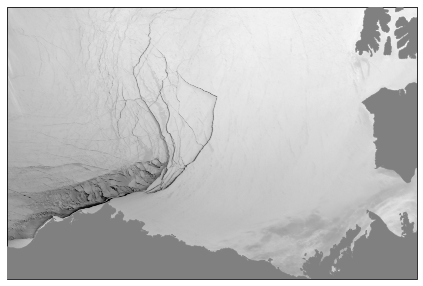

map extent: (-830720.024788086, 830720.024788084, -2366645.1648669443, -1263934.2279286038)

>>> save image as ./example/MOD021KM.A2013051.2250_image.png


In [5]:
# create figure in NorthPolarStereo projection
#---------------------------------------------
map_projection = ccrs.NorthPolarStereo(central_longitude=215)
lat_range = [68.5, 78]
lon_range = [235, 195]#[-125, -165]
fig, ax = plt.subplots(subplot_kw=dict(projection=map_projection),figsize=(10,5), facecolor='white')
ax.spines['geo'].set_edgecolor('k')

# set map extent and add geo features
#------------------------------------
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())  
add_coast(ax, scale='10m', color='gray', linewidth=0.5, alpha=1, zorder=10)
add_land(ax, scale='10m', color='gray', alpha=1, fill_dateline_gap=True, zorder=9)

# plot imagery
#-------------
for ii in range(len(_image_)):
    ax.pcolormesh(_lon_[ii], _lat_[ii], _image_[ii], cmap='Greys', vmin=2, vmax=5.5, shading='gouraud', transform=ccrs.PlateCarree())
plt.show()

# get map extent
#---------------
EXT = ax.get_extent()
print(f'map extent: {EXT}\n')

# save image  
#-----------
SaveName = f'./example/{ImageName}_image.png'
print(f'>>> save image as {SaveName}') 
fig.savefig(SaveName, bbox_inches="tight", pad_inches = 0, dpi=300)


# (2) Extracting lead coordinates from projected image

Manually select some lead coordinates and use [sci-kit image active contour model](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.active_contour) to fill in additional coordinates between selected points based on the brightness contrast across leads in thermal images.

Resources for scikit-image active contour model:
 - https://scikit-image.org/docs/dev/api/skimage.segmentation.html
 - https://tirthajyoti.github.io/Scikit-image-book/Active_contour_model.html


---
### (2A) List sea ice imagery files from specified directory

In [6]:
# specify folder to search for image made in part (1)
#====================================================
filepath = './example/'
#====================================================

print_string = f'Files ending in "_image.png" found in {filepath}'
print(f'{print_string}\n{"-"*len(print_string)}')

# read in list of .png files ending with '_image' in filepath
png_list = glob.glob1(filepath, "*_image.png");

# grab dates of imagery files, then sort png list by date 
date_list = [get_MODISdate(png_list[i]) for i in np.arange(len(png_list))]
sorted_png_list = [png_list[i] for i in np.argsort(date_list)]
for ii in range(len(sorted_png_list)):
    print(f'[{ii}] {get_MODISdate(sorted_png_list[ii])} --- {sorted_png_list[ii]}')
    

Files ending in "_image.png" found in ./example/
------------------------------------------------
[0] 2013-02-20 22:50:00 --- MOD021KM.A2013051.2250_image.png


---
### (2B) Select and plot image

 >>> opening ./example/MOD021KM.A2013051.2250_image.png


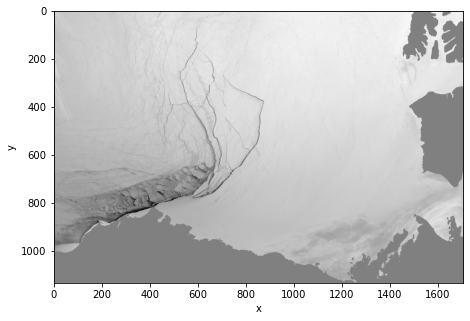

In [7]:
# specify number of image to process from list in (2A)
#=====================================================
image_index = 0
#=====================================================

# read in image
#--------------
image_path = filepath+sorted_png_list[image_index]
lead_date = date_list[image_index]
print(f' >>> opening {image_path}')
IM = io.imread(image_path)

# plot
#-----
plt.figure(figsize=[10,5])
plt.imshow(IM, 'gray_r');
plt.xlabel('x');
plt.ylabel('y');

---
### (2C) Specify projection used and extent of mapped image

Map extent in [NorthPolarStereo projection](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html#northpolarstereo) should have been printed in part (1C).


In [8]:
# specify projection and extent of NP stereographic map above
#============================================================
map_projection = ccrs.NorthPolarStereo(central_longitude=215)

NPS_extent = (-830720.024788084, 830720.024788084, -2366645.1648669443, -1263934.2279286045)
#============================================================

# extent [195, 235, 68.5, 78], central_longitude 215
# ImageCorners = np.array([[196,68],[182,76.5],[248,76.5],[234,68]])

---
### (2D) Use the [TkAgg backend](https://matplotlib.org/stable/users/explain/backends.html) to manually select lead coordinates from clickable image window

#### In the TkAgg window
A separate window with TkAgg backend will pop up. This is an interactive figure window. Click on the image to select coordinates along the lead. Points must be selected sequentially along the lead. You can use the **backspace**/**delete** keyboard keys to remove the last coordinate selection. Once finished, press the **enter**/**return** key on the keyboard to stop point selection. Selected (x,y) coordinates will be stored in the `Coordinates` variable.

#### In the notebook
The TkAgg window will freeze after coordinates have been selected. Return to the notebook to continue to steps (3) and (4). After routine is finished, restarting the notebook kernel will close the TkAgg window.


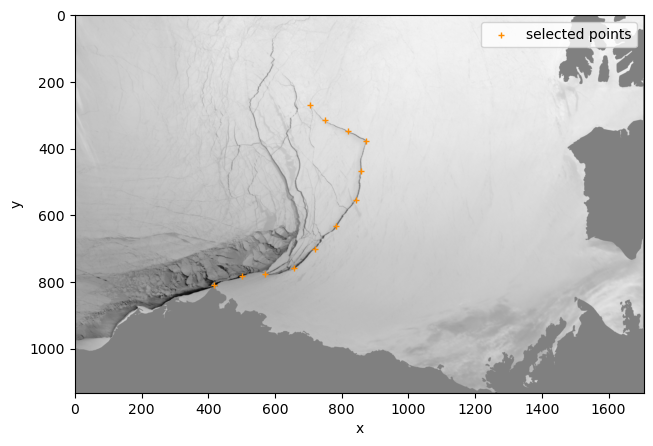

selected points:

|    x   |    y   |
|--------|--------|
| 418.42 | 807.20 |
| 501.01 | 781.05 |
| 571.20 | 774.17 |
| 657.91 | 757.66 |
| 719.84 | 699.85 |
| 783.16 | 632.41 |
| 842.34 | 553.96 |
| 857.48 | 465.87 |
| 873.99 | 377.78 |
| 818.94 | 347.50 |
| 750.12 | 314.47 |
| 704.70 | 269.05 |

>>> save image as ./example/MOD021KM.A2013051.2250_clickpoints.png


In [9]:

# specify image cropping coordinates to zoom in
# on lead pattern for more precise point selection
#=================================================
crop_TOP = 250     # crop from top, specify min Y coordinate to show
crop_RIGHT = 1200  # crop from right side, specify max X coordinate to show
#=================================================

# plot in tkAgg window to grab coordinates
matplotlib.use('TkAgg')

# start new figure window and plot image
fig = plt.figure(figsize=(15,10), dpi=100)
plt.title("- Click on image to select coordinates\n- Press backspace/delete to delete previous click\n- Press enter/return to end")
plt.imshow(IM[crop_TOP:,:crop_RIGHT], cmap = 'gray')
plt.xticks([]);
plt.yticks([]);

# make plot clickable and save clicked points to 'coords'
coords = plt.ginput(-1)

# convert saved coordinates to array
Coordinates = np.empty(shape=(len(coords),2))
for ii in range(0,len(coords)):
    Coordinates[ii, 0] = coords[ii][0]
    Coordinates[ii, 1] = coords[ii][1]+crop_TOP
      
# plot image and points afterward
#--------------------------------
%matplotlib inline
fig = plt.figure(figsize=([10,5]), dpi=100);
plt.imshow(IM, cmap = 'gray');
plt.scatter(Coordinates[:,0], Coordinates[:,1], c='darkorange', marker='+', lw=1, s=25, label='selected points')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# print selected coordinates in image axes units
print('selected points:\n\n|    x   |    y   |\n|--------|--------|')
for ll in range(len(Coordinates)):
    print(f'| {Coordinates[ll][0]:.2f} | {Coordinates[ll][1]:.2f} |')

# save image  
#-----------
SaveName = f"{image_path.split('_')[0]}_clickpoints.png"
print('\n>>> save image as {}'.format(SaveName)) 
fig.savefig(SaveName, bbox_inches="tight", pad_inches = 0, dpi=300)

---
### (2E) Use skimage  [active contour model](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.active_contour) to fill in lead coordinates between clicked points

The skimage active contour model is used to refine and fill in extra points between coordinates selected in part (2D).  

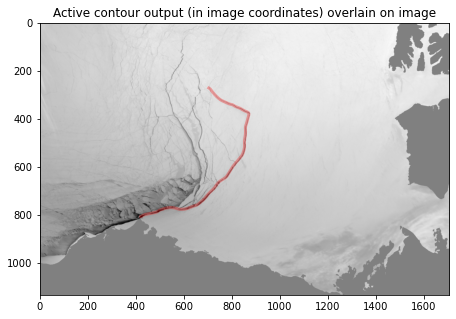


>>> save image as ./example/MOD021KM.A2013051.2250_active_contour_imageoverlay.png


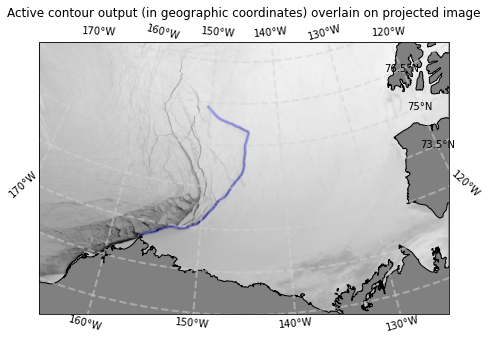


>>> save image as ./example/MOD021KM.A2013051.2250_active_contour_projected.png


In [10]:

# specify number of steps to add between 
# selected points for snake contour-searching
#============================================
num_steps = 50
#============================================

# specify skimage active contour model parameters
#================================================
bound_cond = 'free' # Boundary conditions for the contour.
max_num_iter = 500  # Maximum iterations to optimize snake shape
beta = 100          # Snake smoothness shape parameter. Higher values makes smoother.
w_line = -3         # Attraction to brightness. Negative values attract toward dark.
alpha = 0.05        # Snake length shape parameter. Higher values contract faster.
w_edge = 0          # Attraction to edges. Negative values repel snake from edges.
gamma = 0.5         # Explicit time stepping parameter
#================================================


# set up initial coordinates for active contour model
#----------------------------------------------------
# make array of coordinates with num_steps between each clicked coordinate
row = np.array([])
col = np.array([])
for ii in range(len(Coordinates)-1):
    row = np.append(row, np.linspace(Coordinates[ii,1], Coordinates[ii+1,1], num_steps)[:-1])
    col = np.append(col, np.linspace(Coordinates[ii,0], Coordinates[ii+1,0], num_steps)[:-1])

# stack and transpose x, y coordinate arrays
init = np.array([row, col]).T

# Run active_contour model
#-------------------------
snake = active_contour(IM, init, boundary_condition=bound_cond, alpha=alpha, beta=beta,
                       w_line=w_line, w_edge=w_edge, gamma=gamma, max_num_iter = max_num_iter)

# Plot snake overlay in image
#----------------------------
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Active contour output (in image coordinates) overlain on image');
ax.imshow(IM, cmap=plt.cm.gray)
ax.plot(snake[:, 1], snake[:, 0], c='red', lw=3, alpha=0.3)
ax.axis([0, IM.shape[1], IM.shape[0], 0])
plt.show()

# save image  
#-----------
SaveName = f"{image_path.split('_')[0]}_active_contour_imageoverlay.png"
print('\n>>> save image as {}'.format(SaveName)) 
fig.savefig(SaveName, bbox_inches="tight", pad_inches = 0, dpi=300)


# Transform coordinates from imagery axes to 
# latitude/longitude values
#-------------------------------------------
# find percentage of snake coordinates along image axes
dir1 = 1-snake[:,0]/IM.shape[0]
dir2 = snake[:,1]/IM.shape[1]

# find percentage of snake coordinates along projection axes
x0, x1, y0, y1 = NPS_extent
dir1_proj = y0+(dir1)*(y1-y0)
dir2_proj = x0+(dir2)*(x1-x0)

# convert coordinates to lon/lat
Points = ccrs.PlateCarree().transform_points(map_projection,dir2_proj,dir1_proj)[:,0:2]
lon = Points[:,0]
lat = Points[:,1]

# Plot snake coordinates in lat/lon over re-mapped image
# to check active contour model and coordinate transform
#-------------------------------------------------------
fig, ax = plt.subplots(subplot_kw=dict(projection=map_projection), figsize=(10,5));
ax.set_title('Active contour output (in geographic coordinates) overlain on projected image');
ax.imshow(IM, 'gist_gray', origin='upper', extent=NPS_extent, transform=map_projection)
ax.plot(lon, lat,  c='blue', alpha=0.25, lw=3, transform = ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=1);
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='lightgray', alpha=0.5, linestyle='--');
# ax.plot(dir2_proj,dir1_proj, c='b', alpha=0.5, lw=2,  transform = map_projection)
plt.show() 

# save image  
#-----------
SaveName = f"{image_path.split('_')[0]}_active_contour_projected.png"
print('\n>>> save image as {}'.format(SaveName)) 
fig.savefig(SaveName, bbox_inches="tight", pad_inches = 0, dpi=300)

---
### (2F) Save raw lead coordinates

In [11]:
# specify directory to save lead corodinates
#===========================================
out_path = './example/'
#===========================================

# create data frame
df = pd.DataFrame({'latitude': lat,'longitude': lon})

# save data frame
date_string = lead_date.strftime('%Y%j.%H%M')
out_file = out_path+'lead_{}_raw.csv'.format(date_string)
print('>>> save raw lead coordinates as {}'.format(out_file))
df.to_csv(out_file, index=False)

>>> save raw lead coordinates as ./example/lead_2013051.2250_raw.csv


# (3) Re-indexing lead coordinates to 5-km geodesic steps

Use [geopy](https://geopy.readthedocs.io/en/stable/) and [metpy](https://unidata.github.io/MetPy/latest/index.html#) to re-index/interpolate lead coordinates to fall along 5-km geodesic steps. 

---
### (3A) List raw lead coordinate files from specified directory

In [12]:
# path to search for csv files of raw lead coordinates
# that were saved in step (2E)
#=====================================================
csv_filepath = './example/'
#=====================================================

# path to save updated csv files
#=====================================================
save_filepath = './example/'
#=====================================================

# specify naming convention for new csv files
# {} will be replaced with lead date from
# existing csv file names
#=====================================================
LeadSaveName = 'Lead_{}_5km.csv'
#=====================================================

# grab list of csv files in txt_filepath and print
csv_list = sorted(list(glob.glob1(csv_filepath, "*_raw.csv")));
print(f'>>> Searching for lead coordinates ending in "_raw.csv" in {csv_filepath}\n')
print(f'>>> {len(csv_list)} csv file{(len(csv_list)>1)*"s"} found')
print(f'>>> output file{(len(csv_list)>1)*"s"} will be saved in {save_filepath}')



>>> Searching for lead coordinates ending in "_raw.csv" in ./example/

>>> 1 csv file found
>>> output file will be saved in ./example/


---
### (3B) Re-index and save lead coordinates along 5 km geodesic steps

Coordinates will be imported from `csv_filepath` specified in (3A) and re-indexed/interpolated where needed to place them along 5 km geodesic steps. Updated lead coordinates will be saved to `save_filepath` as specified in (3A).

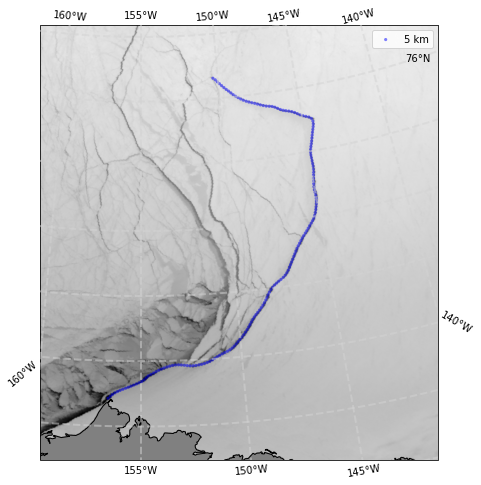


>>> save image as ./example/MOD021KM.A2013051.2250_lead_5_km.png
>>> save updated coordinates as ./example/Lead_2013051.2250_5km.csv


In [13]:
for II in range(len(csv_list)):

    # import raw lead coordinates
    #----------------------------
    import_coords = pd.read_csv(csv_filepath+csv_list[II])
    
    # interpolate points along lead at 5 +/- 0.5 km steps
    #--------------------------------------------------
    LatArray, LonArray = make_SpacedArray(import_coords.values, step_km = 5, error_km = 0.5)

    # create figure
    #--------------
    map_projection_2 = ccrs.NorthPolarStereo(central_longitude=205)
    lon_range = [LonArray.min()-3, LonArray.max()+3]   # specify lon range to plot
    lat_range = [LatArray.min()-1, LatArray.max()+0.5]   # specify lat range to plot
    fig, ax = plt.subplots(subplot_kw=dict(projection=map_projection_2), figsize=(8,8));
    ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=2, color='lightgray', alpha=0.5, linestyle='--', zorder=3)
    ax.imshow(IM, 'gist_gray', origin='upper', extent=NPS_extent, transform=map_projection)
    ax.coastlines();
    
    # plot re-indexed points
    #-----------------------
#     ax.plot(LonArray, LatArray, 'k-', lw=1, transform = ccrs.PlateCarree(), zorder=1)
    ax.scatter(LonArray, LatArray, c='blue', s=10, alpha=0.5, edgecolor='None', transform = ccrs.PlateCarree(), zorder=1, label='5 km')
    
    # plot original points
    #---------------------
#     og_lats = import_coords.latitude.values
#     og_lons = import_coords.longitude.values
#     og_lons[og_lons<0]+=360
#     ax.plot(og_lons, og_lats, 'r-', lw=10, alpha=0.5, transform = ccrs.PlateCarree(), zorder=0, label='original')
    
    plt.legend();
    plt.show()
    
    # save image  
    #-----------
    SaveName = f"{image_path.split('_')[0]}_lead_5_km.png"
    print('\n>>> save image as {}'.format(SaveName)) 
    fig.savefig(SaveName, bbox_inches="tight", pad_inches = 0, dpi=300)
    
    # save new file
    #--------------
    # create data frame
    df = pd.DataFrame({'latitude': LatArray,'longitude': LonArray})
    # save data frame
    lead_date = csv_list[II].split('_')[1]
    Altered_SaveName = save_filepath+LeadSaveName.format(lead_date)
    print('>>> save updated coordinates as {}'.format(Altered_SaveName))
    df.to_csv(Altered_SaveName, index=False)

    fig.clear()
